# 3.2: Classification / Regression

**Runtime: ~60 mins**

*In this section I am using GridSearchCV to find the best performing models for each dataset. For the Stars dataset, the model that is tested is the SVC model and for the GWP dataset - SVR. When the best model has been found, appropriate graphs and statistics are displayed for the final model for each dataset.*

## Importing required libraries & modules
*Modules required for this task are impored below.*

In [1]:
import numpy as np
from ipynb.fs.defs.task3_1 import load_dataset, encode_dataset, simple_imputer,\
    iterative_imputer, scale_data, select_best_features
from sklearn.model_selection import train_test_split, KFold, GridSearchCV,\
    cross_val_score
from sklearn.svm import SVC, SVR
import matplotlib.pyplot as plt
from sklearn.metrics import ConfusionMatrixDisplay, roc_curve, auc

## Load and pre-process datasets
*Datasets are loaded and pre-processed using functions from Task 3.1*

In [2]:
def pre_process_dataset(name: str, features_count: int,\
                        categorical_data: bool=False) -> np.ndarray:
    """
    Function that returns the pre-processed dataset using functions
    from task3_1.ipynb that import, encode, replaces missing values
    and selects best features from it.
    
    Args:
        name (str): The name of the dataset to import
        features_count (int): The number of features to select from 
            the dataset
        categorical_data (bool): If only categories should be imputed
            using Simple Imputer
    
    Returns:
        np.ndarray: The pre-processed dataset
    """
    
    dataset = load_dataset(name)
    encoded_set_info = encode_dataset(dataset, 'one-hot-encoder')
    encoded_dataset = encoded_set_info[0]
    imputed_dataset = iterative_imputer(simple_imputer(encoded_dataset,\
                                encoded_set_info[1], only_categories=True))
    scalled_dataset = scale_data(imputed_dataset, 'min-max')
    best_features_dataset = select_best_features(scalled_dataset, features_count,\
                                                 categorical_data)
    
    return best_features_dataset

In [3]:
# Assign pre-processed datasets
if __name__ == "__main__":
    stars_dataset = pre_process_dataset('star_assessment.csv', 12, categorical_data=True)
    gwp_dataset = pre_process_dataset('gwp_assessment.csv', 5)

## Splitting datasets into training and testing
*Datasets are split into training and testing subsets. To determine whether to use 80/20 ratio or 70/30, a cross validation test will be conducted to see which split fits each dataset better.*

In [4]:
def split_dataset(dataset: np.ndarray, test_size: float=0.3) -> np.ndarray:
    """
    Function that splits dataset into training and testing and
    returns two subsets. Test size is configurable.
    
    Args:
        dataset (np.ndarray): The dataset to be split
        test_size (float): the test size as float
        
    Returns:
        np.ndarray: x_train, x_test, y_train, y_test
    """
    
    x_train, x_test, y_train, y_test = train_test_split(dataset[:,:-1],\
                                        dataset[:,-1], test_size=test_size)
    
    return x_train, x_test, y_train, y_test

Testing different splits on the **GWP Dataset**. Both 80/20 and 70/30 splits will be tested to see which one has better performance.

In [16]:
if __name__ == "__main__":
    xtr_80_gwp, xte_80_gwp, ytr_80_gwp, yte_80_gwp = \
        split_dataset(gwp_dataset, 0.2)
    xtr_70_gwp, xte_70_gwp, ytr_70_gwp, yte_70_gwp = \
        split_dataset(gwp_dataset)
    
    scores_80_gwp = cross_val_score(SVR(), xtr_80_gwp, ytr_80_gwp, cv=5)
    scores_70_gwp = cross_val_score(SVR(), xtr_70_gwp, ytr_70_gwp, cv=5)
    print('Score from 80/20 split: {0} \nScore from 70/30 split: {1}'\
          .format(scores_80_gwp.mean(), scores_70_gwp.mean()))

Score from 80/20 split: 0.2873352118650454 
Score from 70/30 split: 0.3237387774049002


In conclusion using 70/30 split returns higher accuracy and therefore will be used for the **GWP dataset**.

Testing different splits on the **Stars Dataset**. Both 80/20 and 70/30 splits will be tested to see which one has better performance.

In [6]:
if __name__ == "__main__":
    xtr_80_s, xte_80_s, ytr_80_s, yte_80_s = \
        split_dataset(stars_dataset, 0.2)
    xtr_70_s, xte_70_s, ytr_70_s, yte_70_s = \
        split_dataset(stars_dataset)
    
    scores_80_stars = cross_val_score(SVC(), xtr_80_s, ytr_80_s, cv=5)
    scores_70_stars = cross_val_score(SVC(), xtr_70_s, ytr_70_s, cv=5)
    print('Score from 80/20 split: {0} \nScore from 70/30 split: {1}'\
          .format(scores_80_stars.mean(), scores_70_stars.mean()))

Score from 80/20 split: 0.9375499999999999 
Score from 70/30 split: 0.9362142857142857


In conclusion using 80/20 split returns higher accuracy and therefore will be used for the **Stars dataset**.

In [7]:
# Split datasets
if __name__ == "__main__":
    x_train_stars, x_test_stars, y_train_stars, y_test_stars = split_dataset(stars_dataset, 0.2)
    x_train_gwp, x_test_gwp, y_train_gwp, y_test_gwp = split_dataset(gwp_dataset)

## Finding optimal hyper-parameters using GridSearchCV
*To find the best-performing hyper-parameters for both models used, namely **SVR** for the GWP dataset and **SVC** for the Stars dataset, I am using **GridSearchCV**. It works by performing exhaustive search over specified hyper-parameters on each model and evaluates their performances. I am using **KFold** which further splits each dataset into k consecutive folds, where each fold is used to train a model.* \
*Since a model could take long time to run, to optimise the runtime, I have added `n_jobs=-1` parameter to the **GridSearchCV** which utilizes the **maximum** number of CPU cores to achieve parallelizing and maximum efficiency*

In [8]:
def return_optimal_model(model: (SVC, SVR), dataset: np.ndarray,\
                         param_grid: dict, n_splits: int=5) -> list:
    """
    Function that will test a range of hyper-parameters using SVC or 
    SVR model to find the optimal parameters that produce the best result.
    Returns configuration of best model, list of parameters tested,
    list of mean scores from each test, list of std scores from each test.
    
    Args:
        model (SVC, SVR): The model on which hyper-parameters should be tested
        dataset (np.ndarray): The dataset with which tests should be conducted
        param_grid (dict): The parameters which should be tested
        n_splits (int): The number of folds in which data to be split so that
            it can be tested for each parameter of the model
    
    Returns: list
        [0]: best parameters from the search
        [1]: list of all parameters tested
        [2]: mean scores from testing
        [3]: standard deviation scores from testing
    """
    
    kf = KFold(n_splits=n_splits)
    
    grid_search = GridSearchCV(model, param_grid, cv=kf, n_jobs=-1)
    grid_search.fit(dataset[:,:-1], dataset[:,-1])
    
    return[
        grid_search.best_params_,
        grid_search.cv_results_['params'],
        grid_search.cv_results_['mean_test_score'],
        grid_search.cv_results_['std_test_score']
    ]

## Stars dataset: Finding optimal hyper-parameters for *SVC* model
*Different hyper-parameters are tested on the **SVC** model.*

In [9]:
# Running hyper-parameter optimisation on the start set
if __name__ == "__main__":
    param_grid = {
        'C': [0.1, 1, 10],
        'kernel': ['rbf', 'linear'],
        'gamma': [0.5, 1]
    }
    best_model_stars, tested_stars, mean_scores_stars,\
    std_scored_stars = return_optimal_model(SVC(), stars_dataset, param_grid)

## Stars dataset: Visualise results from hyper-parameters optimisation

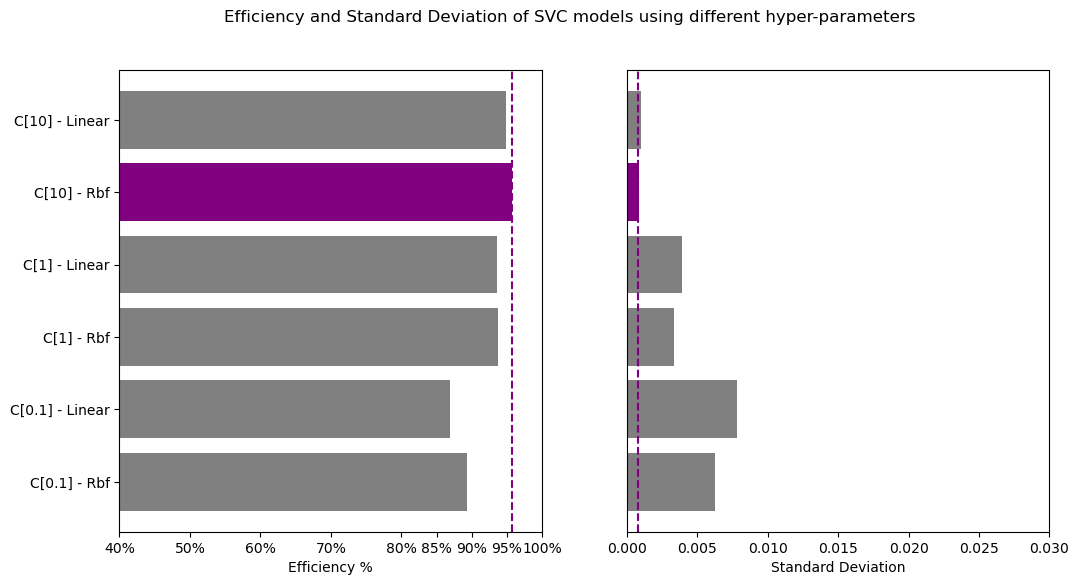

In [10]:
# Visualise results from hyper-parameters
if __name__ == "__main__":
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 6))

    labels = ["C[{0}] - {1}".format(d['C'], d['kernel'].capitalize()) for d in tested_stars]
    colors = ['grey'] * len(tested_stars)
    colors[tested_stars.index(best_model_stars)] = 'purple'

    ax1.barh(labels, mean_scores_stars, color=colors)
    ax1.set_xticks([0.4, 0.5, 0.6, 0.7, 0.8, 0.85, 0.9, 0.95, 1.0])
    ax1.set_xticklabels(['40%', '50%', '60%', '70%', '80%', '85%', '90%', '95%', '100%'])
    ax1.set_xlim(0.4, 1.0)
    ax1.axvline(x=mean_scores_stars.max(), color='purple', linestyle='--')
    ax1.set_xlabel('Efficiency %')

    ax2.barh(labels, std_scored_stars, color=colors)
    ax2.set_xlabel('Standard Deviation')
    ax2.set_xlim(0, 0.03)
    ax2.yaxis.set_visible(False) 
    ax2.axvline(x=std_scored_stars.min(), color='purple', linestyle='--')

    fig.suptitle('Efficiency and Standard Deviation of SVC models using different hyper-parameters')
    plt.show()

## Stars dataset: Conclusion from results
*As we can see from the hyper-parameters optimisation the SVC model with parameters **C=10** and **kernel=rbf** is the best performing model with efficiency of 95.1% and standard deviation 0.001.*

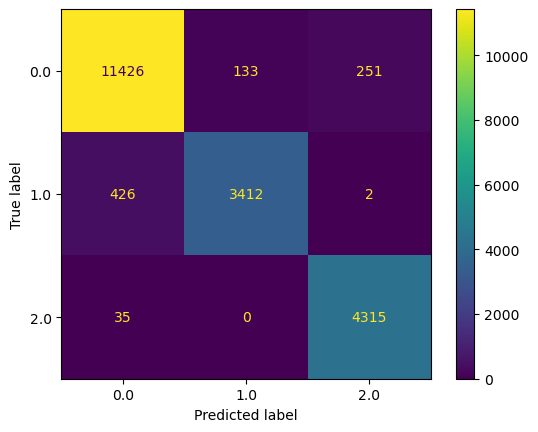

In [17]:
# Run the final model for stars dataset and show ConfusionMatrix
if __name__ == "__main__":
    svc = SVC(C=10, kernel='rbf')
    svc.fit(x_train_stars, y_train_stars)
    y_pred_stars = svc.predict(x_test_stars)
    svc.score(x_test_stars, y_test_stars)

    ConfusionMatrixDisplay.from_predictions(y_test_stars, y_pred_stars)
    plt.show()

## Gwp dataset: Finding optimal hyper-parameters for *SVR* model
*Different hyper-parameters are tested on the SVR model.*

In [12]:
if __name__ == "__main__":
    param_grid = {
        'C': [0.1, 1, 5],
        'kernel': ['sigmoid', 'rbf'],
        'gamma': [0.25, 0.5, 1]
    }
    best_model_gwp, tested_gwp, coef_scores_gwp,\
    std_scored_gwp = return_optimal_model(SVR(), gwp_dataset, param_grid)

## Gwp dataset: Visualise results from hyper-parameters optimisation

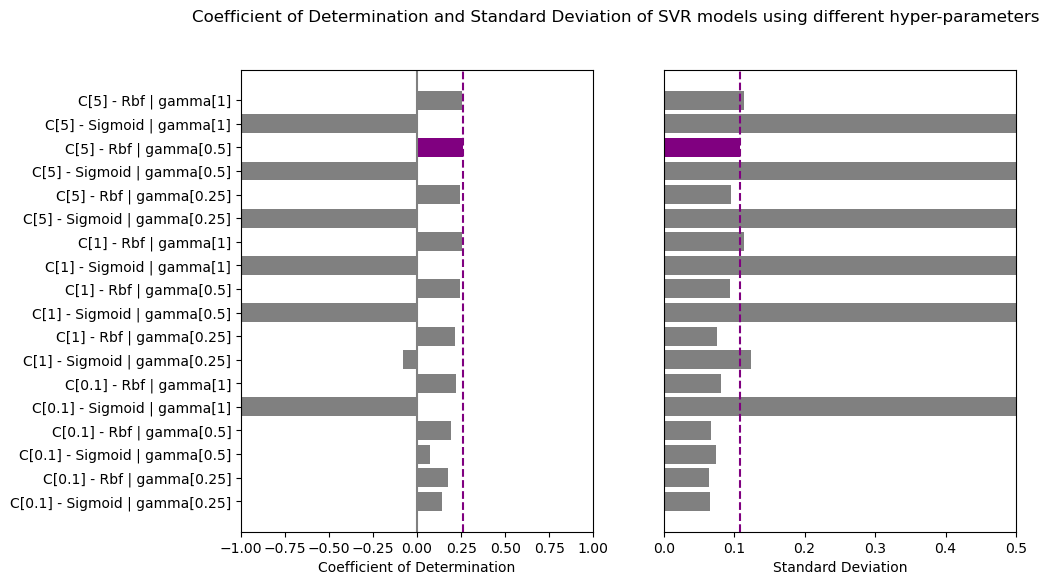

In [13]:
# Visualise results from hyper-parameters
if __name__ == "__main__":
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 6))

    labels = ["C[{0}] - {1} | gamma[{2}]".format(d['C'], d['kernel'].capitalize(), d['gamma']) for d in tested_gwp]
    colors = ['grey'] * len(tested_gwp)
    colors[tested_gwp.index(best_model_gwp)] = 'purple'

    ax1.barh(labels, coef_scores_gwp, color=colors)
    ax1.set_xlim(-1, 1)
    ax1.axvline(x=coef_scores_gwp.max(), color='purple', linestyle='--')
    ax1.axvline(x=0, color='grey', linestyle='solid')
    ax1.set_xlabel('Coefficient of Determination')

    ax2.barh(labels, std_scored_gwp, color=colors)
    ax2.set_xlabel('Standard Deviation')
    ax2.set_xlim(0, 0.5)
    ax2.yaxis.set_visible(False) 
    ax2.axvline(x=std_scored_gwp[tested_gwp.index(best_model_gwp)], color='purple', linestyle='--')

    fig.suptitle('Coefficient of Determination and Standard Deviation of SVR models using different hyper-parameters')
    plt.show()

## Gwp dataset: Conclusion from results
*As I can see from the hyper-parameters optimisation the SVR model with parameters **C=5**, **kernel=rbf** and **gamma=0.5 or 1** are both performing very good. However, as I am looking for the highest coefficient of determination and lowest standard deviation, the model with **gamma=0.5** performs slightly better and therefore is selected as the best performing model with coefficient of determination of **0.263** and standard deviation **0.114**.*

In [14]:
def plot_prediction_results(y_pred_gwp: np.ndarray, y_test_gwp: np.ndarray) -> \
                                (plt.figure, plt.axis):
    """
    Function that will plot the prediction capabilities
    of a model by showing comparison of predicted vs actual
    values and error % for the first 200 values.
    
    Args:
        y_pred_gwp (np.ndarray): The prediction array of the dataset
        y_test_gwp (np.ndarray): The test array of the dataset
    
    Returns: tuple
        plt.figure: Matplotlib figure to be plotted
        plt.axis: Matplotlib axis
    """
    
    fig1, ax1 = plt.subplots(figsize=(10, 6))
    ax1.plot(y_pred_gwp[:200], label='Predicted')
    ax1.plot(y_test_gwp[:200], label='Actual')
    ax1.set_xlabel('Data point')
    ax1.set_ylabel('Value')
    ax1.legend()
    ax1.set_title('Comparison of predicted and actual values for the first 200 values of GWP test set')

    fig2, ax2 = plt.subplots(figsize=(10, 6))
    abs_error = np.abs(y_pred_gwp[:200] - y_test_gwp[:200])
    avg_error = np.mean(abs_error)
    ax2.bar(np.arange(len(abs_error)), abs_error)
    ax2.set_xlabel('Data point')
    ax2.set_ylabel('Error %')
    yticks = np.linspace(0.1, np.max(abs_error)*1.1, 7)
    yticklabels = ['{}%'.format(int(round(y*100, -1))) for y in yticks]
    ax2.set_yticks(yticks)
    ax2.set_yticklabels(yticklabels)
    ax2.axhline(y=avg_error, color='orange', linestyle='--', label='Avg error')
    ax2.set_title('Error % of the first 200 predicted values of GWP test set')
    ax2.legend()
    
    return fig1, ax1

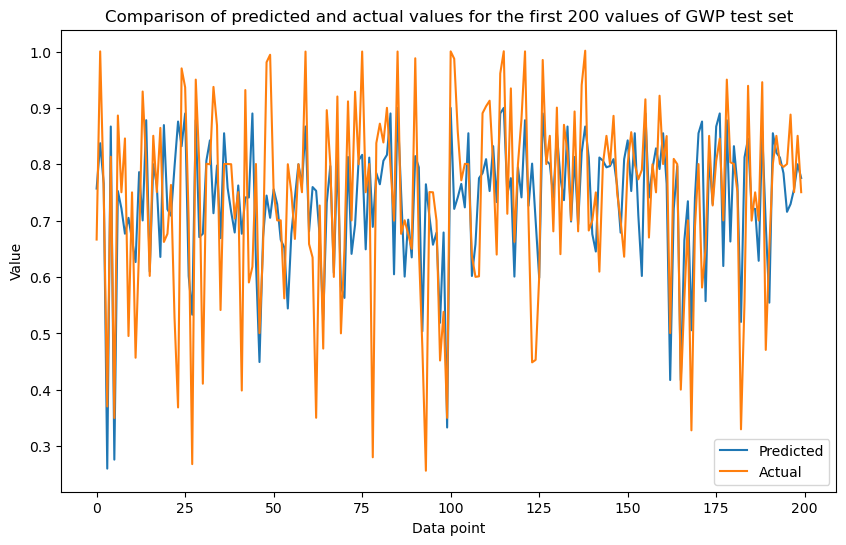

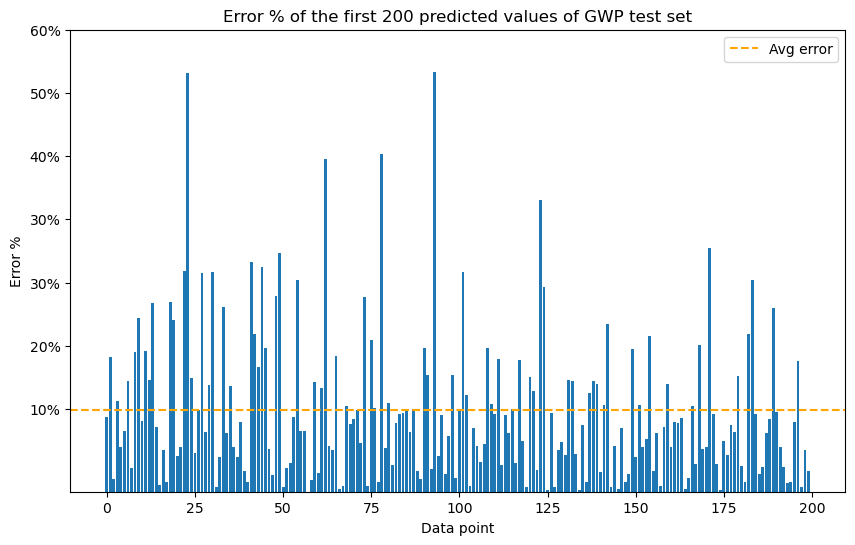

In [15]:
# Run the final model for stars dataset and show ConfusionMatrix
if __name__ == "__main__":
    svr = SVR(C=5, kernel='rbf', gamma=0.5)
    svr.fit(x_train_gwp, y_train_gwp)
    y_pred_gwp = svr.predict(x_test_gwp)
    svr.score(x_test_gwp, y_test_gwp)
    
    fig, ax = plot_prediction_results(y_pred_gwp, y_test_gwp)
    plt.show()